# Detecção de Fraudes com o IsolationForest

# Resumo

# Importando as Bibliotecas

In [37]:
# Manipulação de Dados
import pandas as pd
import numpy as np
import json
import joblib



# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem e Avaliação
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression

# Pré-processamento
from sklearn.preprocessing import (
    StandardScaler,
)
from sklearn.compose import ColumnTransformer


# Funções Auxiliares
import utils.aux_func as af
from utils.paths import (
    SPLITS_DIR,
    ANCHOR_ARTIFACTS_DIR,
    METRIC_ARTIFACTS_DIR
)
from evaluation.business_metric import business_metric


# Configurações Gerais
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.dpi"] = 400
pd.set_option("display.max_columns", None)

# Importando a Base

In [38]:
df_train = pd.read_parquet(SPLITS_DIR / "train.parquet")
df_val   = pd.read_parquet(SPLITS_DIR / "val.parquet")
df_test  = pd.read_parquet(SPLITS_DIR / "test.parquet")

def unpack(df):
    X = df.drop(columns=["target", "amount"])
    y = df["target"]
    amount = df["amount"]
    return X, y, amount

X_train, y_train, amount_train = unpack(df_train)
X_val, y_val, amount_val = unpack(df_val)
X_test, y_test, amount_test = unpack(df_test)


# Importando a Métrica de Negócio

In [39]:
with open(METRIC_ARTIFACTS_DIR / "business_metric_config.json") as f:
    metric_cfg = json.load(f)

metric_params = {
    "gain_legitimate_accept_rate": metric_cfg["gain_legitimate_accept_rate"],
    "gain_fraud_refuse": metric_cfg["gain_fraud_refuse"],
    "loss_legitimate_refuse": metric_cfg["loss_legitimate_refuse"],
}

sklearn.set_config(enable_metadata_routing=True)

business_scorer = (
    make_scorer(
        business_metric,
        **metric_params
    )
    .set_score_request(amount=True)
)

# Baseline Econômico: Sempre Aprovar as Transações (Always Accept Policy)

Essa política representa um cenário em que nenhuma transação é recusada, independentemente de seu risco. Na prática, ela equivale à ausência completa de um sistema antifraude. Ela acceita todas as transações legítimas e fraudulentas, gerando perdas financeiras proporcionais ao valor das fraudes. Além disso, não há custos associados à recusa indevida de clientes legítimos nem ganhos provenientes de detecção de fraudes.

In [40]:
always_accept_policy = DummyClassifier(strategy="constant", constant=0)
always_accept_policy.fit(X_train, y_train)

benefit_accept = business_scorer(
    always_accept_policy,
    X_test,
    y_test,
    amount=amount_test
)

print(f"O benefício da politica de sempre aceitar as transações é de: {benefit_accept:,.2f}€")

O benefício da politica de sempre aceitar as transações é de: 90,280.45€


# Modelo Ancora Logit

In [41]:
logit_anchor = joblib.load(
    ANCHOR_ARTIFACTS_DIR / "logit_anchor.joblib"
)

with open(ANCHOR_ARTIFACTS_DIR / "threshold.json") as f:
    anchor_threshold = json.load(f)["optimal_threshold"]


In [42]:
y_score_anchor = logit_anchor.predict_proba(X_test)[:, 1]
y_pred_anchor = (y_score_anchor >= anchor_threshold).astype(int)

with open(ANCHOR_ARTIFACTS_DIR / "threshold.json") as f:
    business_test_opt = json.load(f)["business_metric"]

# IsolationForest

In [43]:
# Apenas transações legítimas no treino
X_train_legit = X_train[y_train == 0].copy()

In [44]:
num_features = X_train.columns.tolist()

amount_feature = ["Amount"]
other_features = [c for c in num_features if c != "Amount"]

preprocessor = ColumnTransformer(
    transformers=[
        ("amount_scaler", StandardScaler(), amount_feature),
        ("passthrough", "passthrough", other_features),
    ]
)

iso_forest = IsolationForest(
    n_estimators=300,
    max_samples="auto",
    contamination="auto",   # não define o threshold final
    random_state=42,
    n_jobs=-1
)


iso_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("iso", iso_forest)
    ]
)


iso_pipeline.fit(X_train_legit)

,steps,"[('preprocess', ...), ('iso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('amount_scaler', ...), ('passthrough', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [45]:
# Validação
iso_score_val = -iso_pipeline.decision_function(X_val)

# Teste
iso_score_test = -iso_pipeline.decision_function(X_test)

In [46]:

df_scores_val = pd.DataFrame({
    "anomaly_score": iso_score_val,
    "class": y_val.values
})


df_scores_test = pd.DataFrame({
    "anomaly_score": iso_score_test,
    "class": y_test.values
})

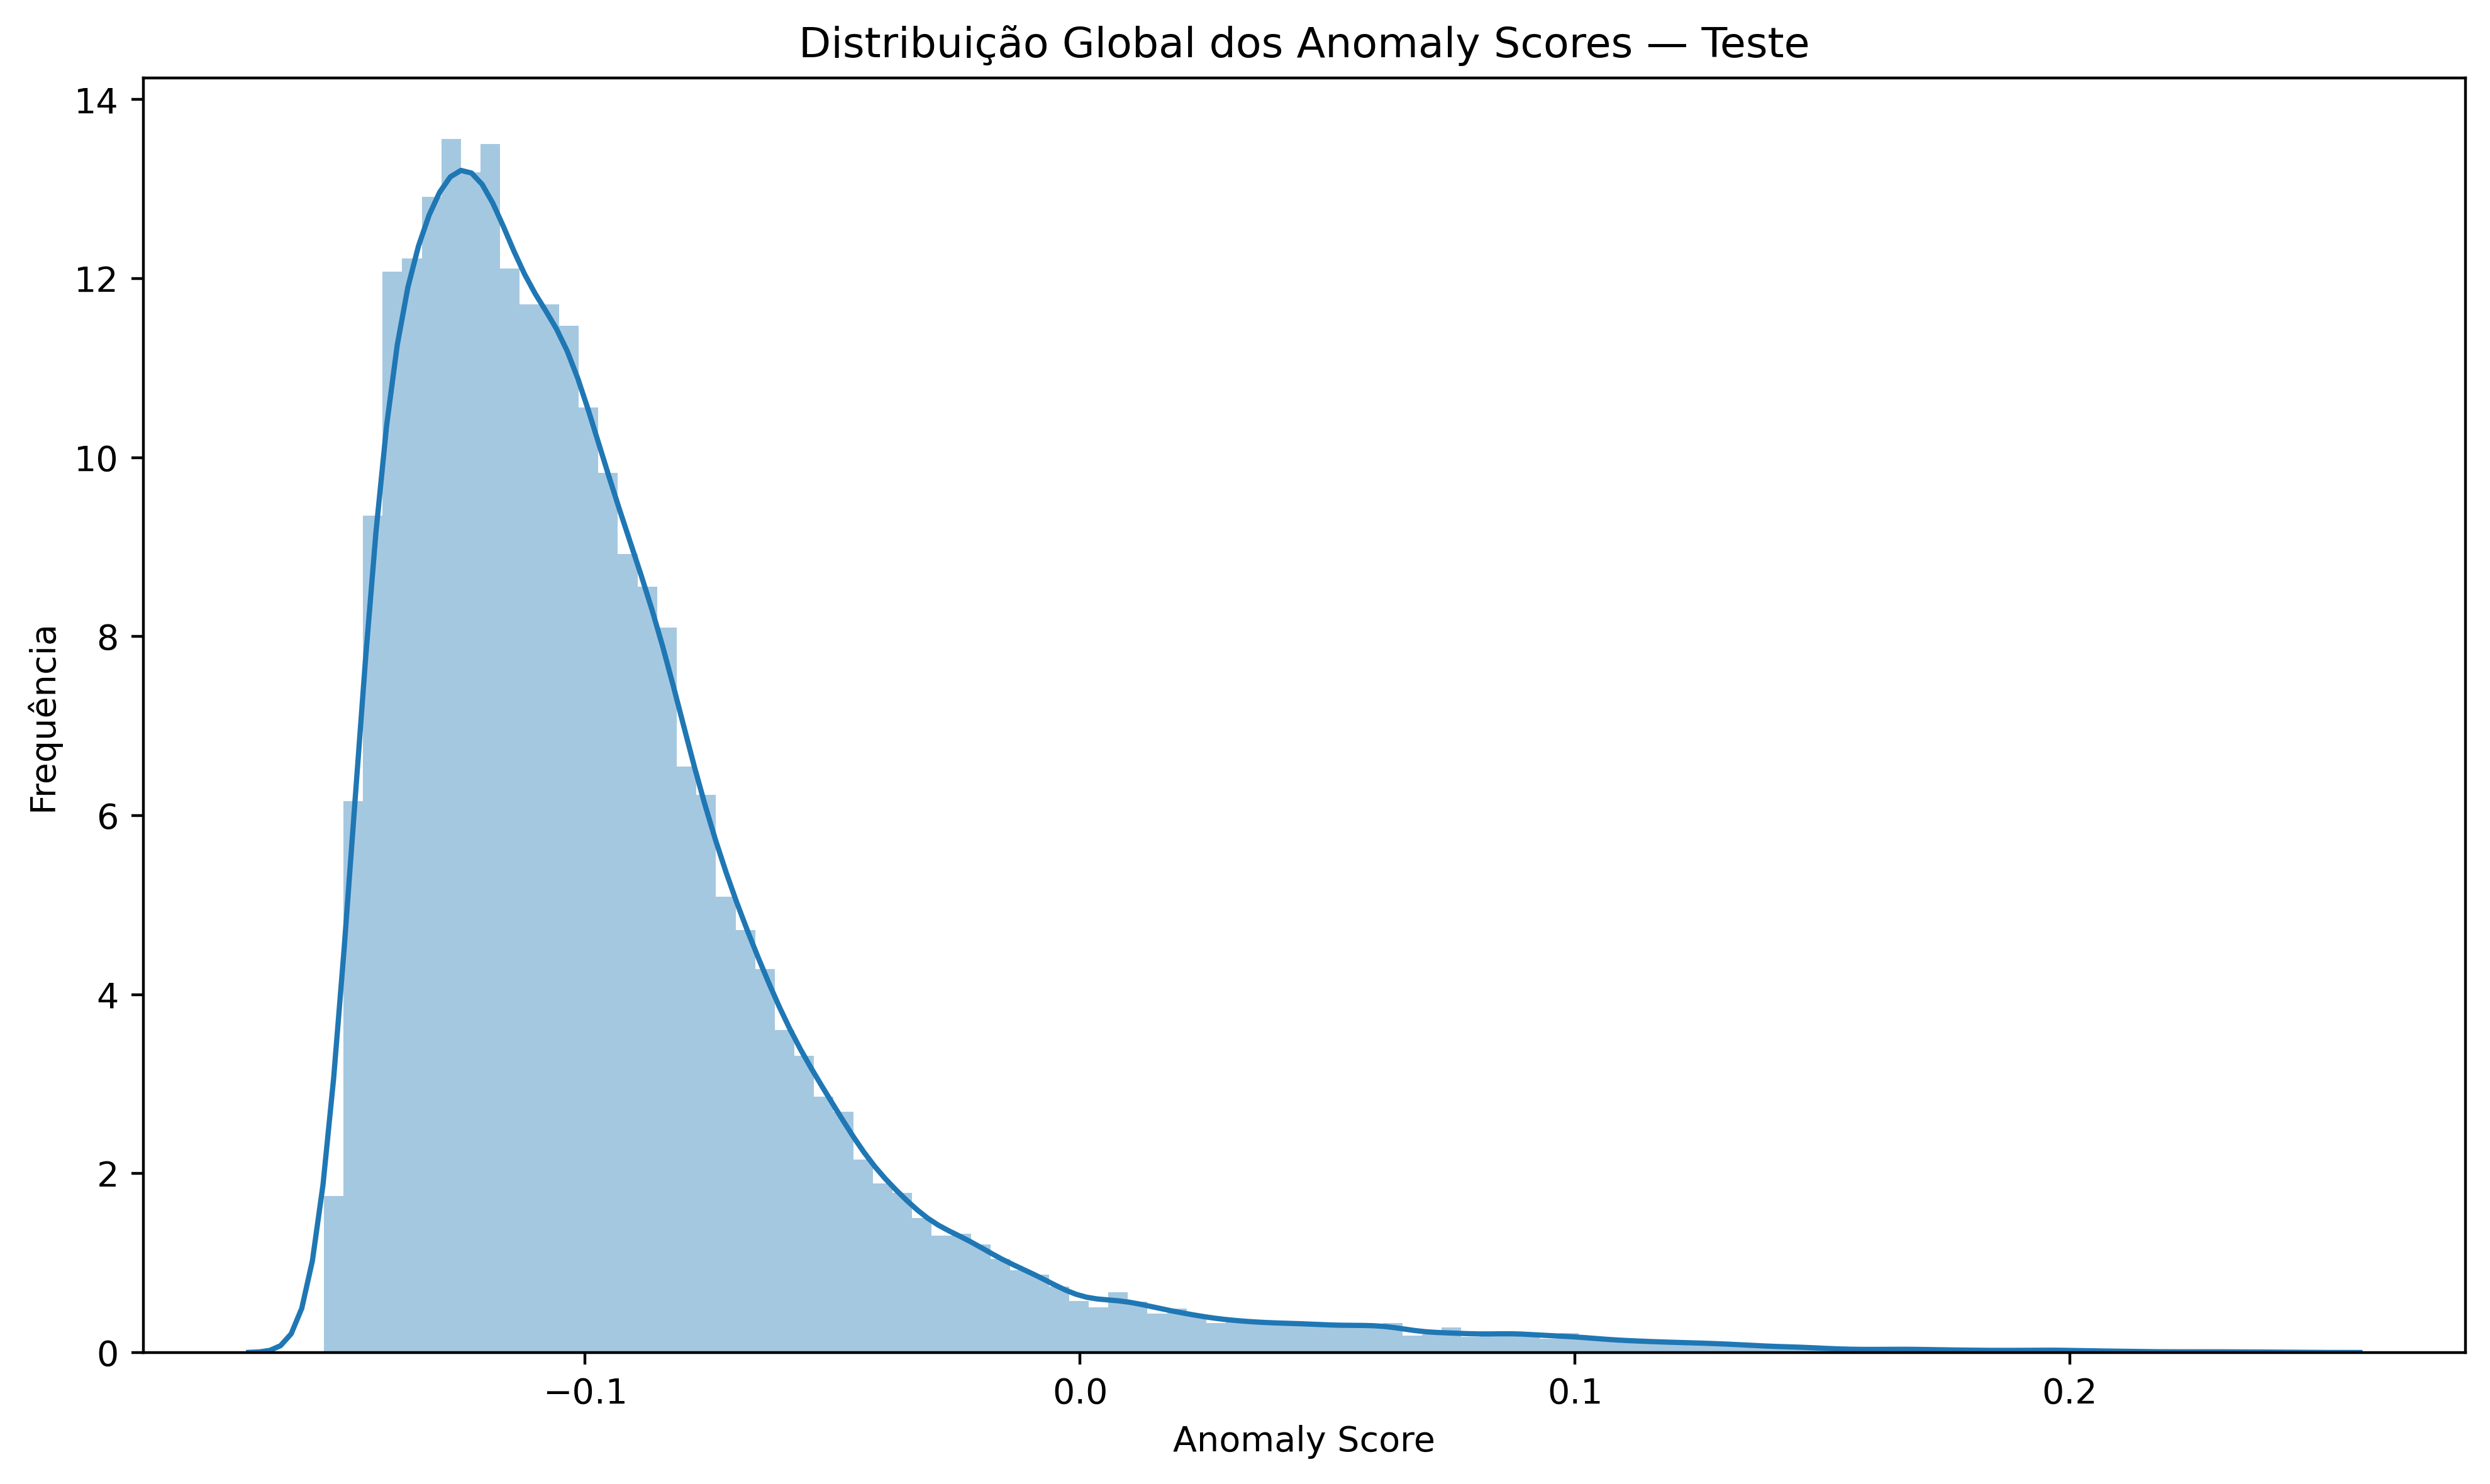

In [47]:

plt.figure(figsize=(10, 6))

sns.distplot(
    df_scores_test["anomaly_score"],
    bins=100,
    kde=True,
    hist=True
)

plt.xlabel("Anomaly Score")
plt.ylabel("Frequência")
plt.title("Distribuição Global dos Anomaly Scores — Teste")
plt.tight_layout()
plt.show()



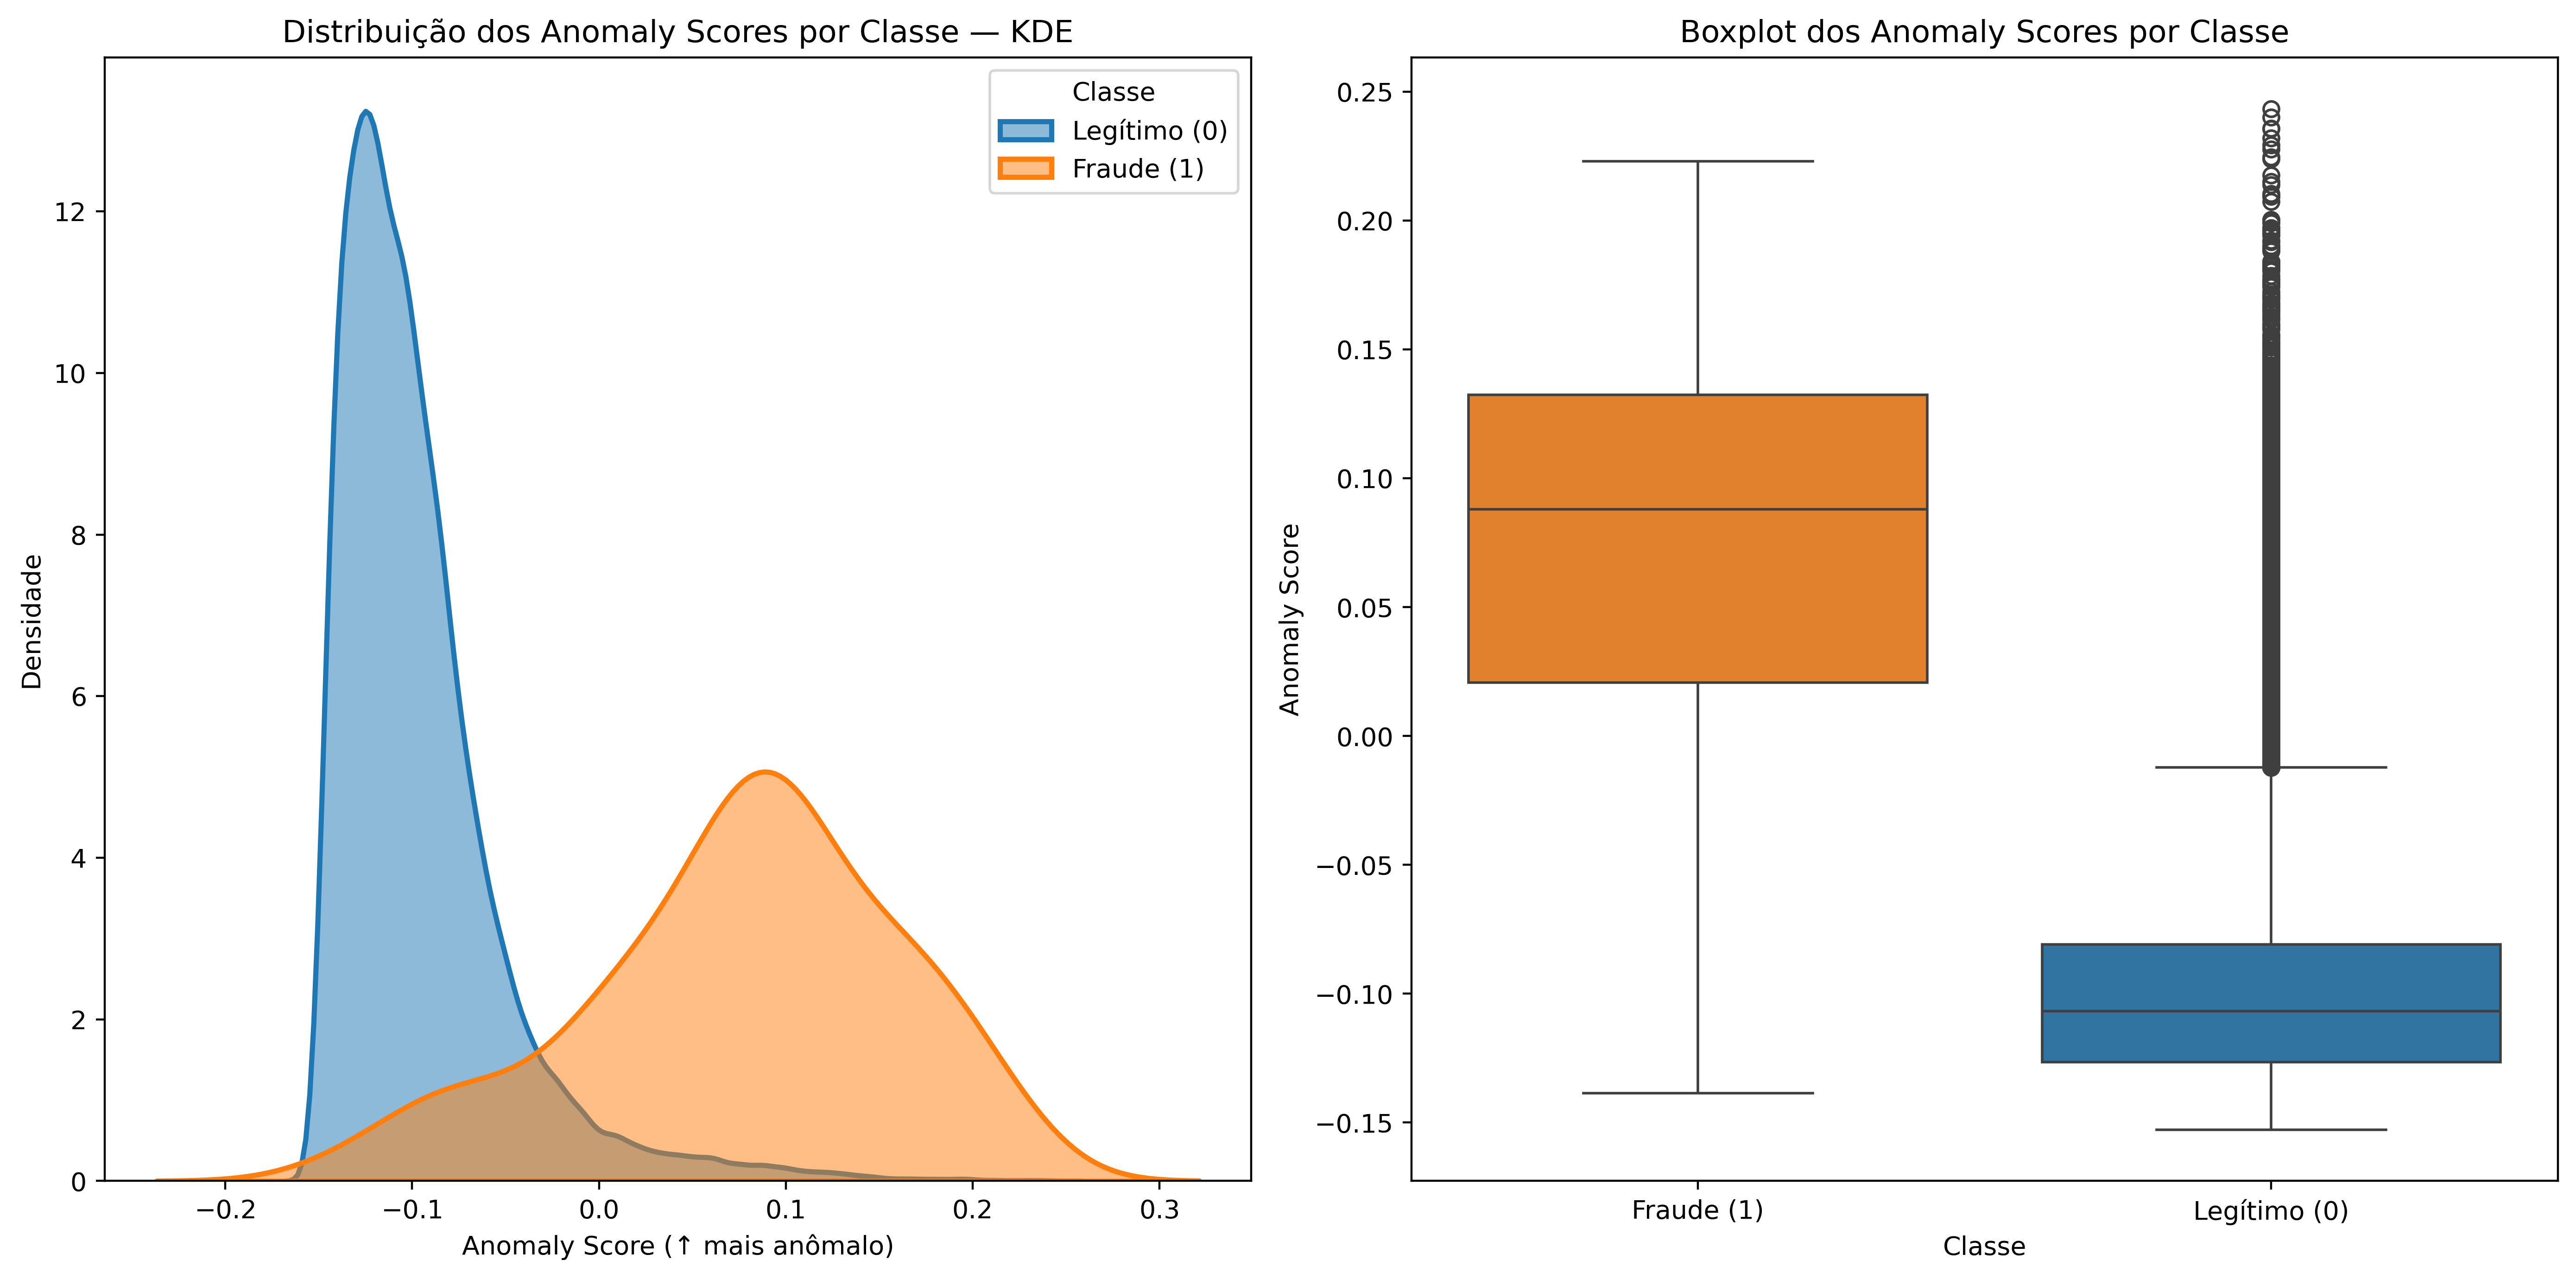

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# =========================
# (1) KDE PLOT
# =========================
sns.kdeplot(
    data=df_scores_test,
    x="anomaly_score",
    hue="class",
    hue_order=[1, 0],  # Fraude primeiro, depois legítimo
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=2,
    palette={0: "tab:blue", 1: "tab:orange"},
    ax=axes[0]
)

axes[0].set_xlabel("Anomaly Score (↑ mais anômalo)")
axes[0].set_ylabel("Densidade")
axes[0].set_title("Distribuição dos Anomaly Scores por Classe — KDE")
axes[0].legend(title="Classe", labels=["Legítimo (0)", "Fraude (1)"])

# =========================
# (2) BOXPLOT
# =========================
sns.boxplot(
    data=df_scores_test,
    x="class",
    y="anomaly_score",
    order=["1", "0"],
    palette={"0": "tab:blue", "1": "tab:orange"},
    ax=axes[1]
)

axes[1].set_xlabel("Classe")
axes[1].set_ylabel("Anomaly Score")
axes[1].set_title("Boxplot dos Anomaly Scores por Classe")
axes[1].set_xticklabels(["Fraude (1)", "Legítimo (0)"])


plt.tight_layout()
plt.show()


In [49]:

thresholds = np.linspace(
    iso_score_val.min(),
    iso_score_val.max(),
    100
)


In [50]:
business_values_if = []

for thr in thresholds:
    y_pred_val = (iso_score_val >= thr).astype(int)
    
    benefit = business_metric(
        y_val,
        y_pred_val,
        amount_val
    )
    
    business_values_if.append(benefit)

business_values_if = np.array(business_values_if)


In [51]:
best_idx_if = np.argmax(business_values_if)
best_threshold_if = thresholds[best_idx_if]

print(f"Threshold ótimo (Isolation Forest): {best_threshold_if:.4f}")
print(f"Benefício na validação: {business_values_if[best_idx_if]:,.2f}€")


Threshold ótimo (Isolation Forest): 0.1416
Benefício na validação: 87,940.52€


In [52]:
y_pred_test_if = (iso_score_test >= best_threshold_if).astype(int)

business_test_if = business_metric(
    y_test,
    y_pred_test_if,
    amount_test
)

print(f"Benefício econômico — Isolation Forest (Teste): {business_test_if:,.2f}€")


Benefício econômico — Isolation Forest (Teste): 90,695.46€


In [53]:
benefit_accept  # baseline: aprovar tudo
ganho_absoluto_if = business_test_if - benefit_accept
ganho_percentual_if = ganho_absoluto_if / benefit_accept * 100

print(f"Ganho absoluto IF: {ganho_absoluto_if:,.2f}€")
print(f"Ganho percentual IF: {ganho_percentual_if:.2f}%")


Ganho absoluto IF: 415.01€
Ganho percentual IF: 0.46%


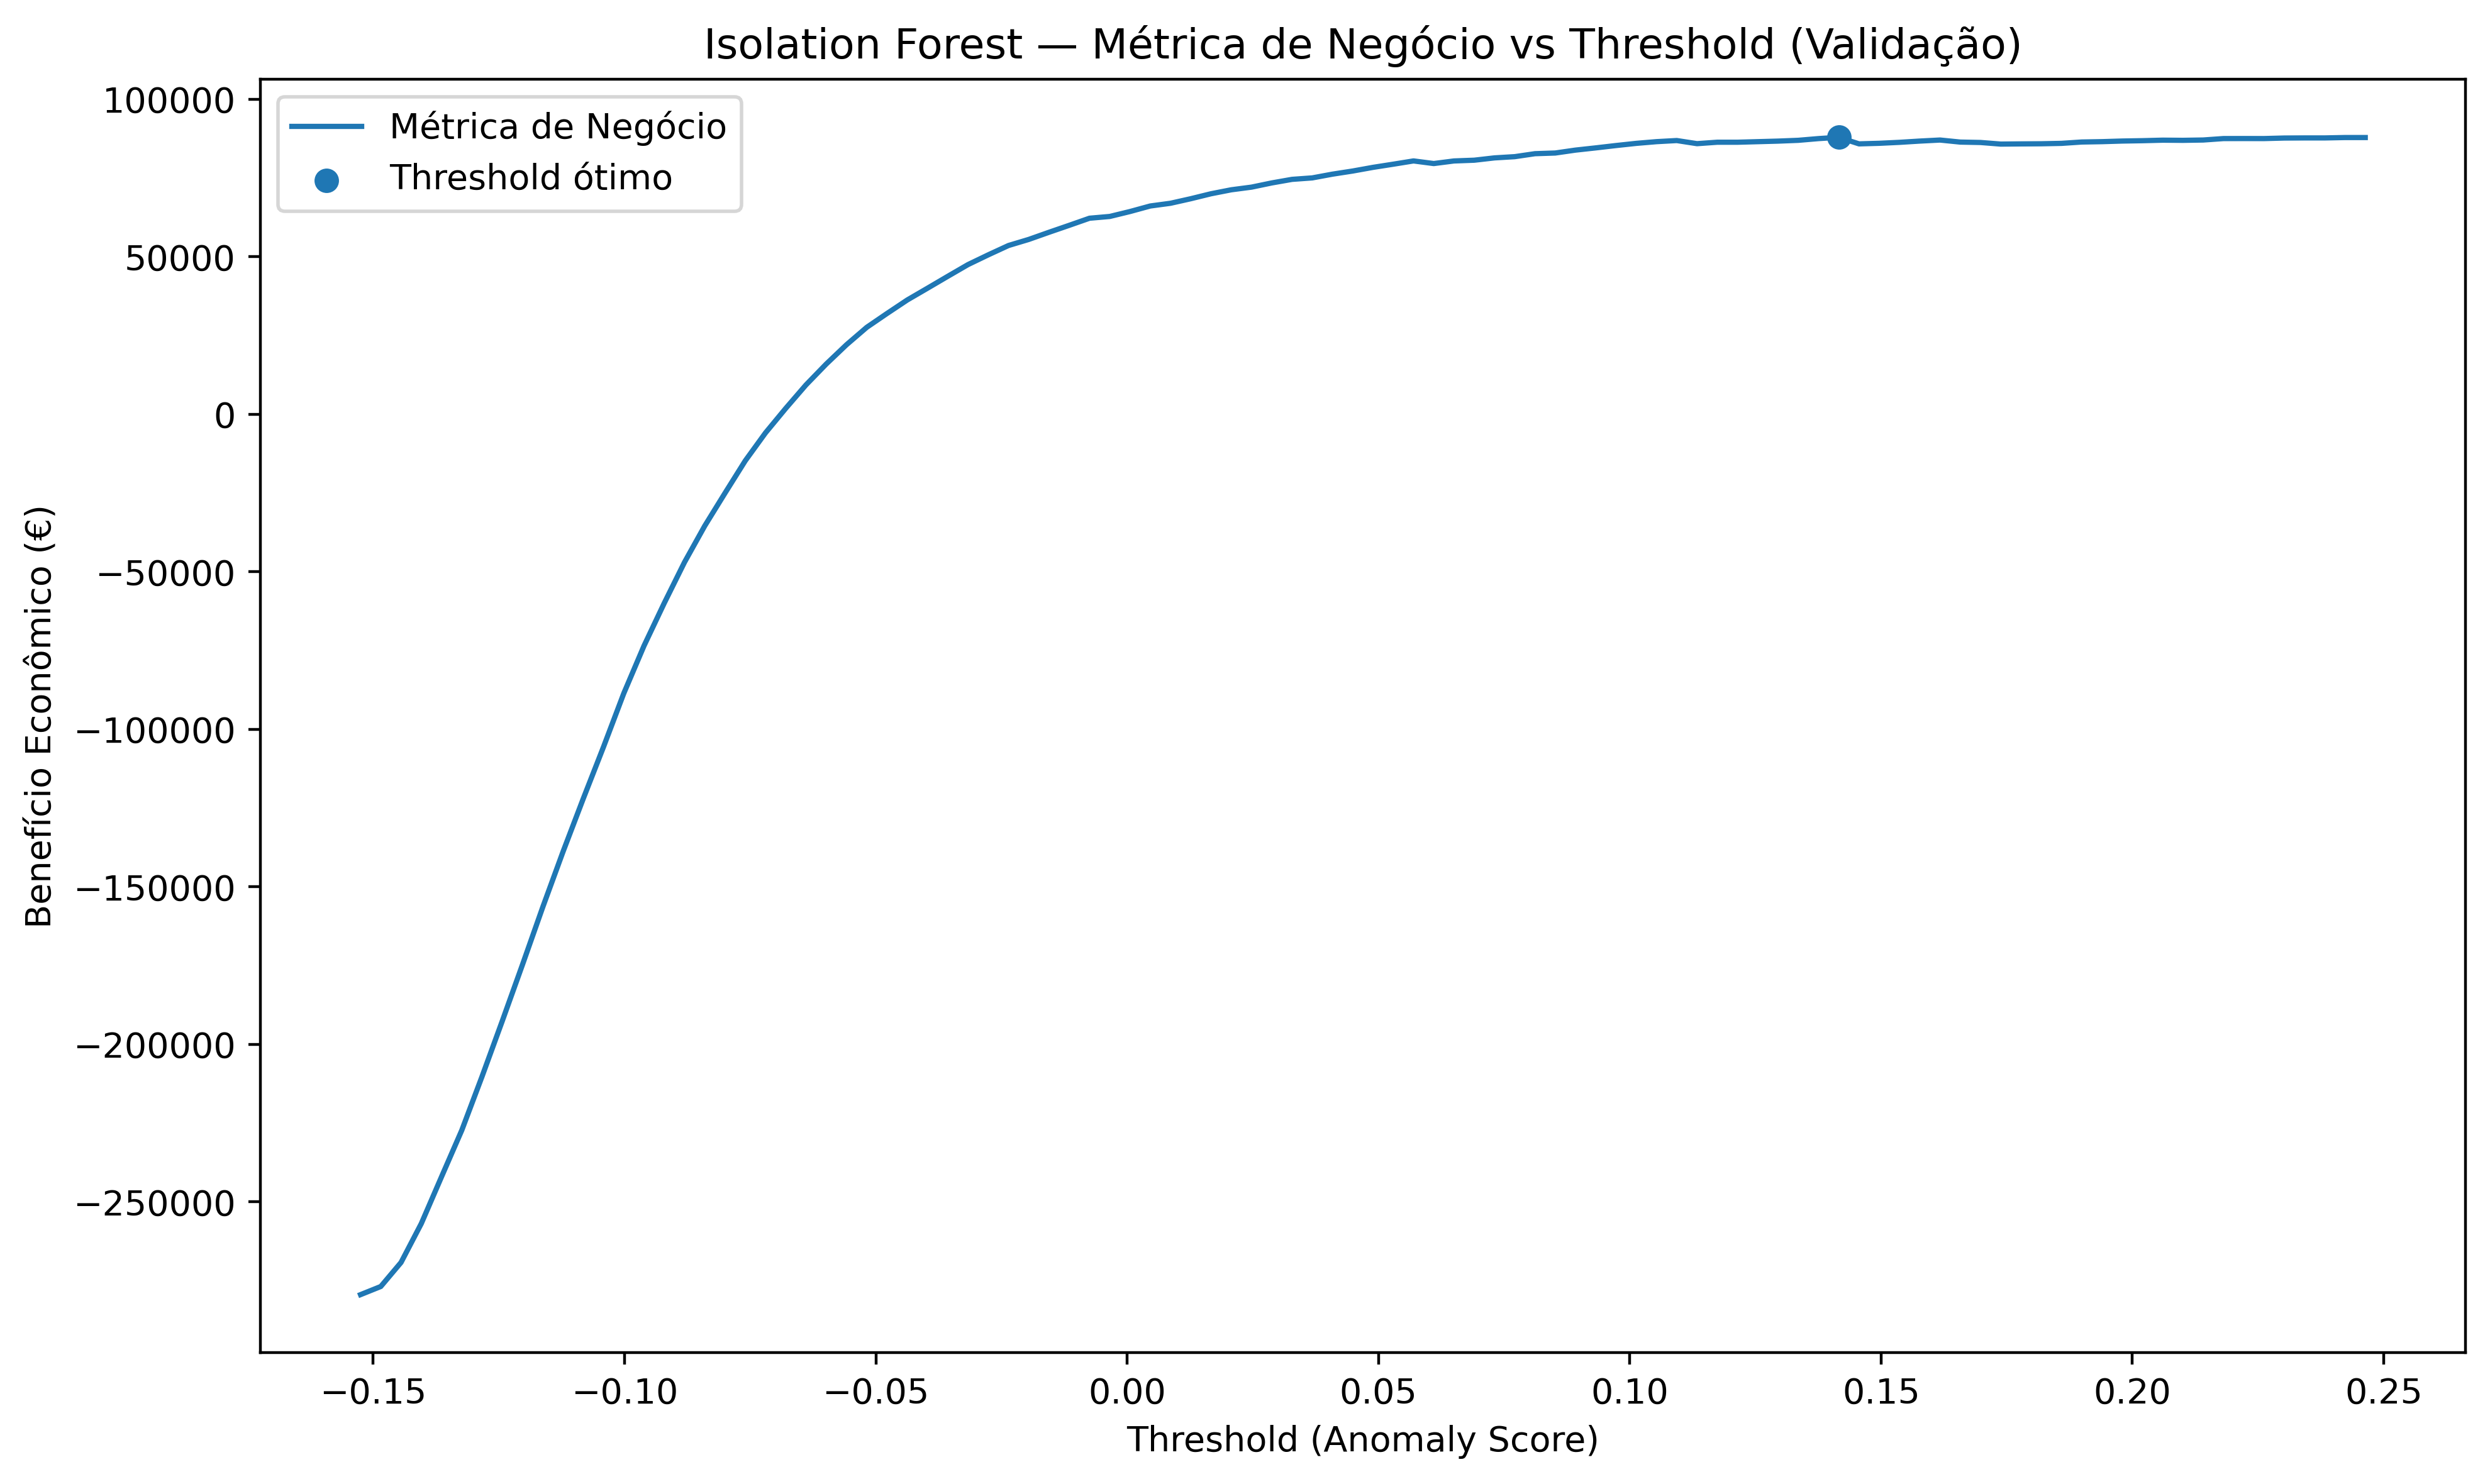

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, business_values_if, label="Métrica de Negócio")
plt.scatter(
    best_threshold_if,
    business_values_if[best_idx_if],
    label="Threshold ótimo",
    zorder=3
)

plt.xlabel("Threshold (Anomaly Score)")
plt.ylabel("Benefício Econômico (€)")
plt.title("Isolation Forest — Métrica de Negócio vs Threshold (Validação)")
plt.legend()
plt.tight_layout()
plt.show()


O Isolation Forest foi avaliado de forma isolada como política de decisão baseada exclusivamente em anomaly scores. Após a otimização do limiar no conjunto de validação, o modelo apresentou ganho econômico positivo no conjunto de teste, com um incremento de € 415,00 em relação ao baseline, correspondente a 0,46%. Embora o impacto isolado seja limitado, o resultado indica que o modelo captura fraudes extremas de alto desvio estatístico. Esse comportamento sugere que o Isolation Forest é mais adequado como mecanismo complementar a modelos supervisionados, atuando como filtro ou sinal auxiliar, do que como decisor principal.

# Avaliando o Blending

## Regra do Veto

In [55]:
y_pred_anchor
y_pred_if    = (iso_score_test >= best_threshold_if).astype(int)

y_pred_or = ((y_pred_anchor  == 1) | (y_pred_if == 1)).astype(int)
y_pred_and = ((y_pred_anchor  == 1) & (y_pred_if == 1)).astype(int)

In [56]:
business_or = business_metric(
    y_test,
    y_pred_or,
    amount_test
)

ganho_or = business_or - benefit_accept
ganho_or_pct = ganho_or / benefit_accept * 100

print("Regra OR")
print(f"Benefício (€): {business_or:,.2f}")
print(f"Ganho absoluto (€): {ganho_or:,.2f}")
print(f"Ganho percentual (%): {ganho_or_pct:.2f}")


Regra OR
Benefício (€): 96,702.18
Ganho absoluto (€): 6,421.73
Ganho percentual (%): 7.11


In [57]:
business_and = business_metric(
    y_test,
    y_pred_and,
    amount_test
)

ganho_and = business_and - benefit_accept
ganho_and_pct = ganho_and / benefit_accept * 100

print("Regra AND")
print(f"Benefício (€): {business_and:,.2f}")
print(f"Ganho absoluto (€): {ganho_and:,.2f}")
print(f"Ganho percentual (%): {ganho_and_pct:.2f}")


Regra AND
Benefício (€): 95,450.54
Ganho absoluto (€): 5,170.10
Ganho percentual (%): 5.73


## Feature

In [58]:
X_train_blend = X_train.copy()
X_val_blend   = X_val.copy()
X_test_blend  = X_test.copy()

X_train_blend["if_score"] = -iso_pipeline.decision_function(X_train)
X_val_blend["if_score"]   = -iso_pipeline.decision_function(X_val)
X_test_blend["if_score"]  = -iso_pipeline.decision_function(X_test)


In [59]:
logit_blend = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", LogisticRegression(
            max_iter=1000,
            solver="lbfgs",
            random_state=42
        ))
    ]
)

logit_blend.fit(X_train_blend, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('amount_scaler', ...), ('passthrough', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [60]:
y_proba_val_blend = logit_blend.predict_proba(X_val_blend)[:, 1]

thresholds = np.linspace(0.01, 0.99, 99)
business_vals = []

for thr in thresholds:
    y_pred_val = (y_proba_val_blend >= thr).astype(int)
    business_vals.append(
        business_metric(y_val, y_pred_val, amount_val)
    )

business_vals = np.array(business_vals)

best_idx = np.argmax(business_vals)
best_thr_blend = thresholds[best_idx]

print(f"Threshold ótimo (Logit + IF): {best_thr_blend:.3f}")


Threshold ótimo (Logit + IF): 0.090


In [61]:
y_proba_test_blend = logit_blend.predict_proba(X_test_blend)[:, 1]
y_pred_test_blend = (y_proba_test_blend >= best_thr_blend).astype(int)

business_blend = business_metric(
    y_test,
    y_pred_test_blend,
    amount_test
)

ganho_blend = business_blend - benefit_accept
ganho_blend_pct = ganho_blend / benefit_accept * 100

print("Logit + IF (Feature)")
print(f"Benefício (€): {business_blend:,.2f}")
print(f"Ganho absoluto (€): {ganho_blend:,.2f}")
print(f"Ganho percentual (%): {ganho_blend_pct:.2f}")


Logit + IF (Feature)
Benefício (€): 101,457.26
Ganho absoluto (€): 11,176.82
Ganho percentual (%): 12.38


In [62]:
df_final = pd.DataFrame({
    "Modelo": [
        "Baseline",
        "Logit",
        "IsolationForest",
        "Logit OR IF",
        "Logit AND IF",
        "Logit + IF (Feature)"
    ],
    "Benefício (€)": [
        benefit_accept,
        business_test_opt,
        business_test_if,
        business_or,
        business_and,
        business_blend
    ]
})

df_final["Ganho vs Baseline (€)"] = (
    df_final["Benefício (€)"] - benefit_accept
)

df_final["Ganho vs Baseline (%)"] = (
    df_final["Ganho vs Baseline (€)"] / benefit_accept * 100
)

df_final


,Modelo,Benefício (€),Ganho vs Baseline (€),Ganho vs Baseline (%)
0,Baseline,90280.446289,0.000000,0.000000
1,Logit,101457.268600,11176.822311,12.380114
2,IsolationForest,90695.455566,415.009277,0.459689
3,Logit OR IF,96702.177979,6421.731689,7.113093
4,Logit AND IF,95450.541504,5170.095215,5.726705
5,Logit + IF (Feature),101457.263916,11176.817627,12.380109


# Conclusão

# Próximos Passos